In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

import geopandas as gpd


import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from scipy.ndimage import maximum_filter


import sys
sys.path.append('..')
import importlib

import nsgp_vi
from nsgp_vi import nsgpVI


import pickle

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


In [2]:
df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')

# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]

df['UID'] = df['AID']+df['COLLAR_ID']

#df = df[df.AID!="W81"] # 81 is a resident mislabelled
df['ID'] = df['UID'].astype('category').cat.rename_categories(range(0, df['UID'].nunique())).astype('int')
#df = df[df.ID!=35]
secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60) # hrs
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y # debug

print(np.shape(X))
print(np.shape(T))



/maths/ctorney/anaconda3/envs/tf2.6/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_3351/2075877874.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values


(94007, 2)
(94007, 1)


/tmp/ipykernel_3351/2075877874.py:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


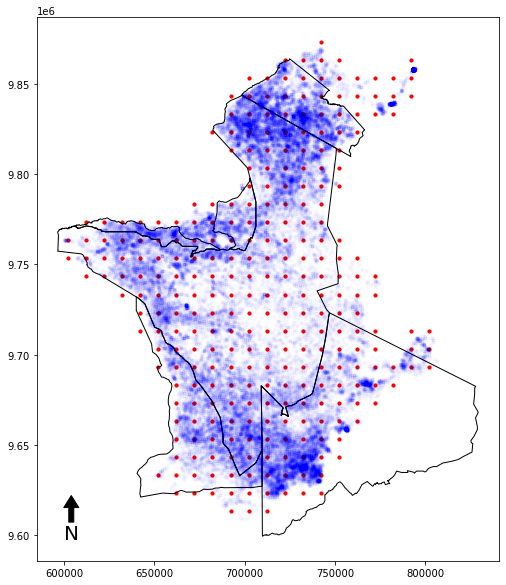

290

In [4]:

# Set up the grid - previous code
offset = 1#50
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>1]
yy = yy[H>1]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

num_inducing_points_ = x_grid.shape[0]


np.random.shuffle(x_grid)

#x_grid += np.random.normal(scale=0.1*gridwidth,size=x_grid.shape)
num_inducing_points_

x_grid.shape
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
plt.show()

num_inducing_points_

In [11]:
# create the dataset

BATCH_SIZE=4
SEG_LENGTH=500

allT = []
allX = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<=SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])

num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0]//SEG_LENGTH)*SEG_LENGTH
print('..',num_training_points_,'..')

.. 84000 ..


In [12]:

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        #self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.j += 1
        
        if (self.j+1)*SEG_LENGTH > T.shape[0]:
            self.i+=1
            self.j=0

        return TT,XX,0.5*(XX[:-1]+XX[1:])

dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,2]))) 
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset = dataset.with_options(options)
#dataset = dataset.repeat(5)


2022-07-01 09:57:59.302800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 09:58:07.991583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


In [16]:
# in case we need to reload
importlib.reload(nsgp_vi)
from nsgp_vi import nsgpVI

In [17]:
kernel_len_a = tfp.util.TransformedVariable(1.0,tfb.Softplus(), dtype=tf.float64, name='k_len_a',trainable=1)
kernel_amp_a = tfp.util.TransformedVariable(1.0,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=1)

kernel_amp_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.0)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
kernel_len_l = tfp.util.TransformedVariable(15.0,tfb.Chain([tfb.Scale(np.float64(10.0)),tfb.Shift(np.float64(1.0)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)

#kernels on the lower layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)


init_observation_noise_variance = 1e-5 # corresponds to a 3m s.d.
untransformed_obs_noise = np.log(np.exp(init_observation_noise_variance)-1) 


vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
             inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
             segment_length = SEG_LENGTH,init_observation_noise_variance=untransformed_obs_noise,
             num_sequential_samples=1,num_parallel_samples=32,jitter=1e-8) 


2022-07-01 09:58:11.070927: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [18]:


loss = vgp.optimize(BATCH_SIZE, MAX_ITERS=200,lr=0.01,threshold=0.2,window=1,patience=5)#stopping_interval=5, evaluation_interval=20, stopping_threshold=0.1)


  0%|          | 0/200 [00:00<?, ?it/s]2022-07-01 09:58:11.543698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Instructions for updating:
Do not call `graph_parents`.


2022-07-01 09:58:17.670321: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 254977024 exceeds 10% of free system memory.
2022-07-01 09:58:35.579699: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 31872128 exceeds 10% of free system memory.
2022-07-01 09:58:59.944854: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x559c806bbb90
2022-07-01 09:59:37.299883: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 31872128 exceeds 10% of free system memory.
2022-07-01 09:59:37.554886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 254977024 exceeds 10% of free system memory.
Loss 1744.826130:  27%|██▋       | 54/200 [22:31<1:00:54, 25.03s/it]


In [19]:
import matplotlib.ticker as tick
plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon
import matplotlib.font_manager as fm


/tmp/ipykernel_3351/3372557655.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


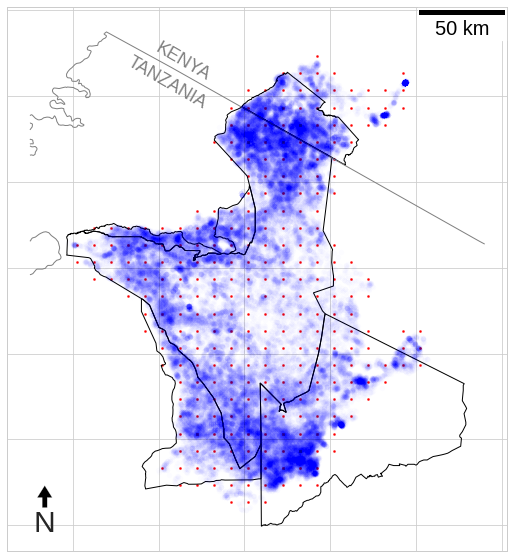

In [20]:

#Inference grid plotted separately 
fontprops = fm.FontProperties(size=14, family='monospace')

df=gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")
dfTZ=gpd.read_file('../data/wildebeest_data/TZ_border_UTM36S.shp')


dfTZ=  dfTZ.to_crs(df.crs)
polygon = Polygon([[5.75e5,9.6e6], [8.4e5,9.6e6], [8.4e5,9.95e6], [5.75e5,9.95e6], [5.75e5,9.6e6]])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=df.crs)
dfTZ = gpd.clip(dfTZ, poly_gdf)
dfTZ = dfTZ.translate(0, 1000)

plt.figure(figsize=(10,10))
plt.tick_params( labelleft=False, labelbottom=False) 
ax = plt.subplot()
df[df.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')
dfTZ.plot(ax=ax,color='gray',linewidth=1)
ax.set_aspect('equal')
ax.add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=ax.transAxes)
ax.text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=ax.transAxes)
ax.text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=ax.transAxes)

plt.plot((x+xmean)*1000,(y+ymean)*1000,'o',c='b',alpha=0.01, mfc=None)
plt.scatter((x_grid.T[0]+xmean)*1000,(x_grid.T[1]+ymean)*1000,s=5,c='r',alpha=1)


plt.savefig('inference_grid.pdf',dpi=300,bbox_inches='tight')

plt.show()


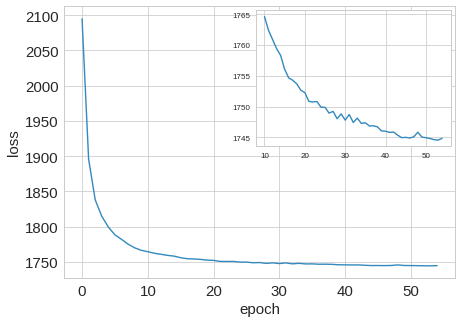

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax0 = plt.subplots(1, 1, figsize=(7,5))#,gridspec_kw={'width_ratios': [1,1,1.5]})
ax0.plot(loss,'-',c='C1')



ax0.set_xlabel('epoch',size=15)
ax0.set_ylabel('loss',size=15)
ax0.tick_params(axis='both', which='major', labelsize=15)
#ax0.set_xlim(-1,NUM_EPOCHS)

ax1 = inset_axes(ax0, width="50%", height="50%", loc=1)

ax1.plot(np.arange(10,len(loss)),loss[10:],'-',c='C1')


# ax1.set_xlabel('epoch',size=15)
# ax1.set_ylabel('loss',size=15)
# ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.set_xlim(24,NUM_EPOCHS)


plt.savefig("serengeti_training_loss.png",dpi=300)

plt.show()

In [22]:

# dense grid for plotting
offset = 0
gridwidth = 2 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=1)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
px_grid = px_grid




In [23]:
locations = px_grid.T[None]
S = 1000
len_samples, var_samples = vgp.get_samples(locations,S)#tf.math.exp(vgp.mean_len + scaled_predictors_len + len_samples)
 #= tf.math.exp(vgp.mean_amp + scaled_predictors_amp + amp_samples)

In [24]:
len_samples = len_samples.numpy()[:,0]
std_samples = var_samples.numpy()[:,0]**0.5

2022-07-01 10:21:05.779827: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 45120000 exceeds 10% of free system memory.


In [25]:
mean_len = np.mean(len_samples,axis = 0)[:, np.newaxis]
std_len = np.std(len_samples,axis = 0)[:, np.newaxis]
mean_std = np.mean(std_samples,axis = 0)[:, np.newaxis]
std_std= np.std(std_samples,axis = 0)[:, np.newaxis]


In [26]:
std_q_25 = np.percentile(std_samples,2.5,axis=0)[:, np.newaxis]
std_q_975 = np.percentile(std_samples,97.5,axis=0)[:, np.newaxis]

len_q_25 = np.percentile(len_samples,2.5,axis=0)[:, np.newaxis]
len_q_975 = np.percentile(len_samples,97.5,axis=0)[:, np.newaxis]

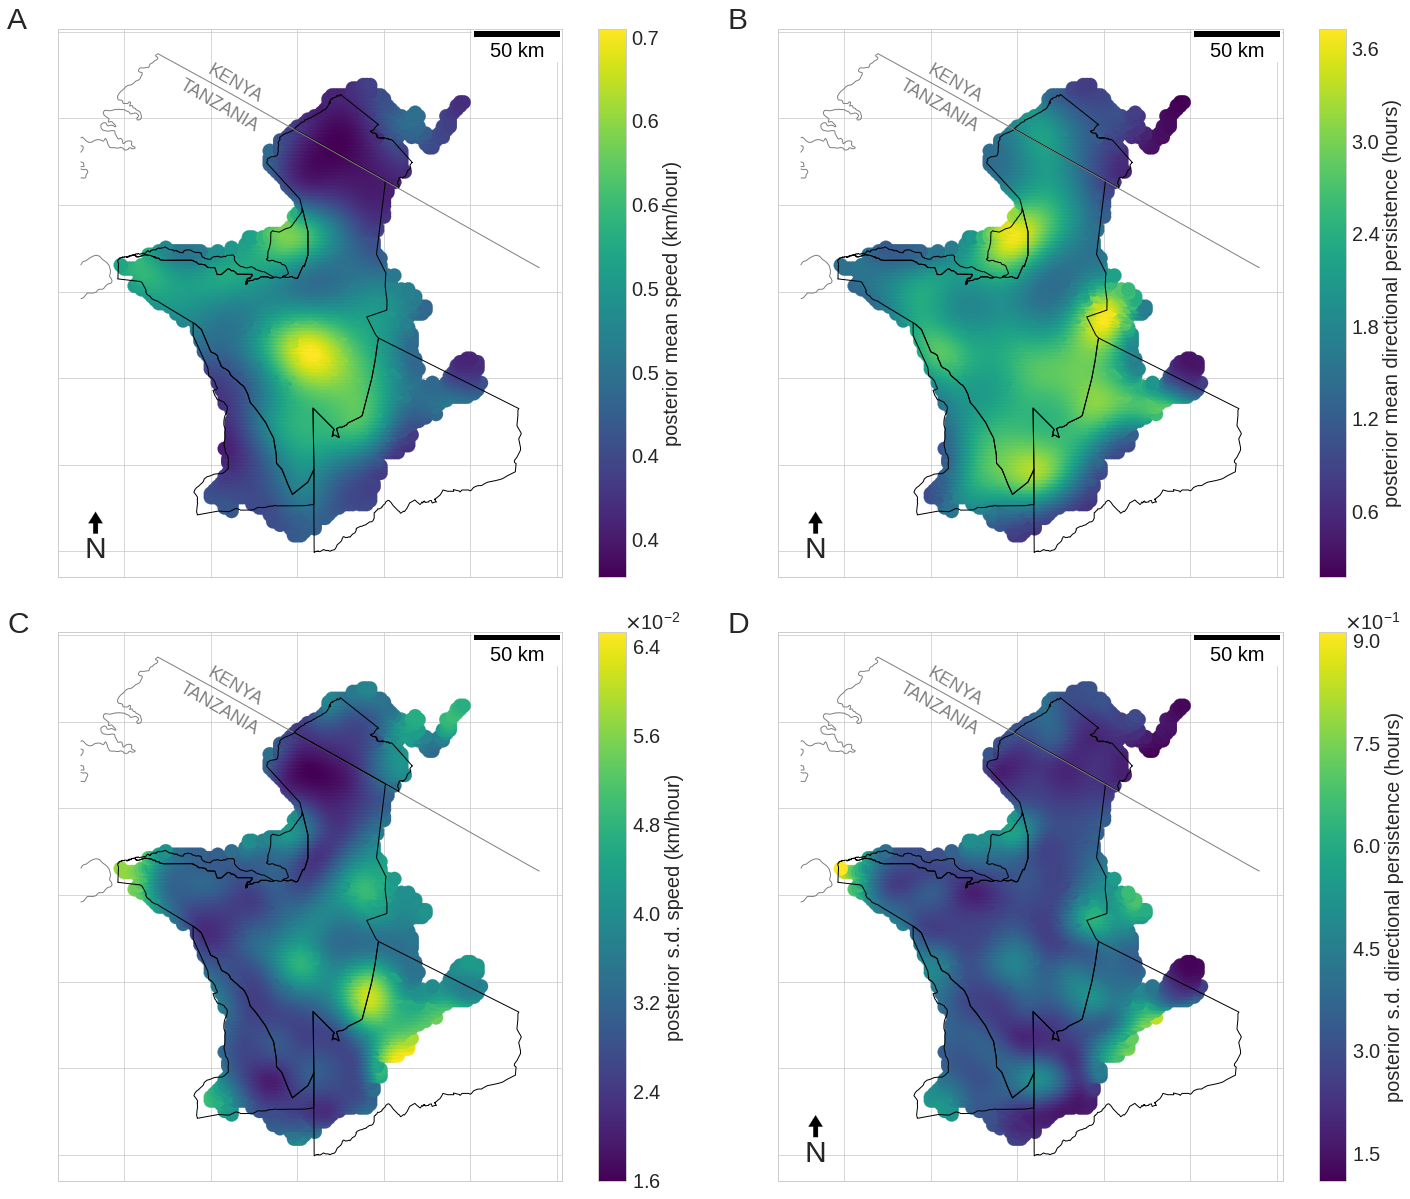

In [31]:
# 2x2 design len and var 

dfborder=gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")
dfTZ=gpd.read_file('../data/wildebeest_data/TZ_border_UTM36S.shp')


dfTZ=  dfTZ.to_crs(dfborder.crs)
polygon = Polygon([[5.75e5,9.6e6], [8.4e5,9.6e6], [8.4e5,9.95e6], [5.75e5,9.95e6], [5.75e5,9.6e6]])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=dfborder.crs)
dfTZ = gpd.clip(dfTZ, poly_gdf)
dfTZ = dfTZ.translate(0, 1000)
fig, axs = plt.subplots(2, 2, figsize=(40,20))

#mean_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
axs[0, 0].set_aspect('equal')
axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,0].transAxes)
axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_std,cmap='viridis',marker='o',s=200)#vmin,vmax
#axs[0,0].set_title('A',loc='left',size=30,pad=100)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)
axs[0,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_var
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
axs[1, 0].set_aspect('equal')
axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,1].transAxes)
axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
ax10 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_std,cmap='viridis',marker='o',s=200)#vmin,vmax
#axs[1,0].set_title('C',loc='center',size=30)
axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1, 0].transAxes)

axs[1,0].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax10, ax=axs[1, 0],format=formatter)
# cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)
cbar.set_label(label='posterior s.d. speed (km/hour)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#mean_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
axs[0, 1].set_aspect('equal')
axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,0].transAxes)
axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
ax01= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=mean_len,cmap='viridis',marker='o',s=200)#vmin,vmax

axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

axs[0,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax01, ax=axs[0, 1],format=tick.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='posterior mean directional persistence (hours)',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std_len
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
axs[1, 1].set_aspect('equal')
axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,1].transAxes)
axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_len,cmap='viridis',marker='o',s=200)#,vmax=0.02,vmin=0)#vmin,vmax

axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

axs[1,1].tick_params( labelleft=False, labelbottom=False) 
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=formatter)
cbar.set_label(label='posterior s.d. directional persistence (hours)',size=20)

cbar.ax.tick_params(labelsize=20) 
cbar.ax.yaxis.offsetText.set_fontsize(20)
cbar.ax.yaxis.offsetText.set_x(3)

tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



plt.tick_params( labelleft=False, labelbottom=False) 
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.0001, 
                    hspace=0.1)


plt.savefig("serengeti_spatial.png",bbox_inches='tight',dpi=300)
plt.show()


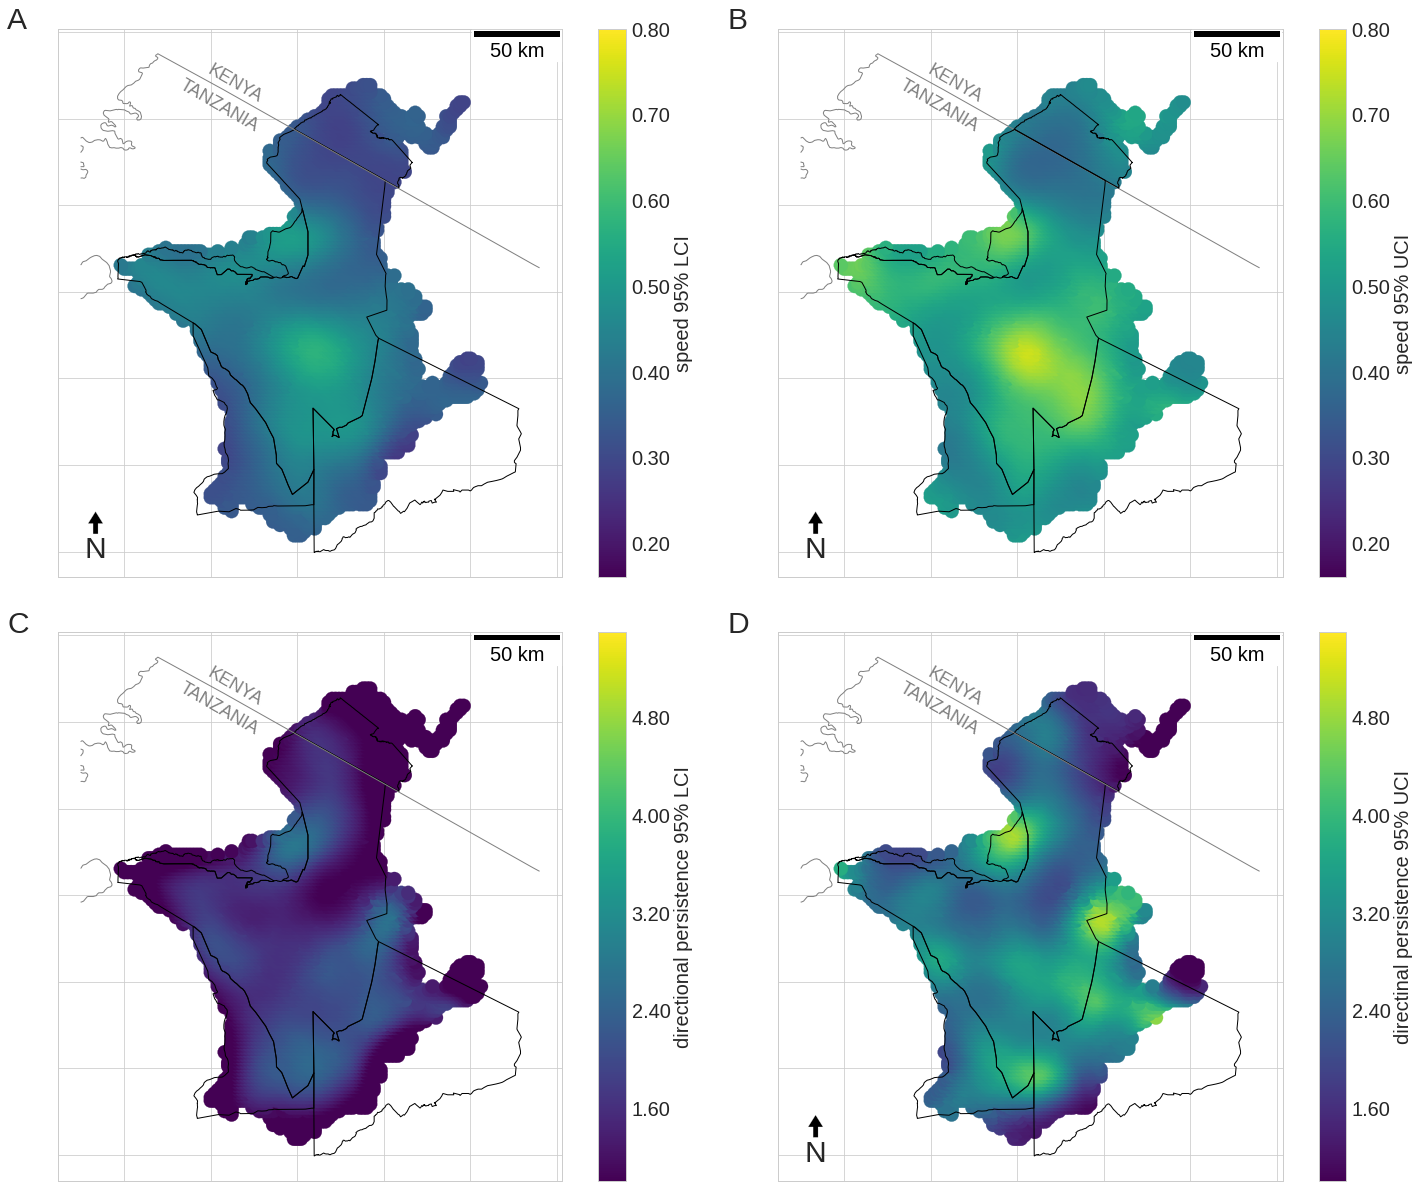

In [30]:


# 2x2 design len and var 


fig, axs = plt.subplots(2, 2, figsize=(40,20))

#std q25
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,0],color='gray',linewidth=1)
axs[0, 0].set_aspect('equal')
axs[0, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,0].transAxes)
axs[0, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,0].transAxes)
axs[0, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,0].transAxes)
ax00 = axs[0, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_25,cmap='viridis',marker='o',s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
#axs[0,0].set_title('A',loc='center',size=30)
axs[0,0].text(-0.1,1,'A', size=30, transform=axs[0, 0].transAxes)

axs[0,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax00, ax=axs[0, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='speed 95% LCI',size=20)

tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()

#std q975
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,0],color='black',linewidth=1)
dfTZ.plot(ax=axs[0,1],color='gray',linewidth=1)
axs[0, 1].set_aspect('equal')
axs[0, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[0, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,0].transAxes)
axs[0,1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[0,1].transAxes)
axs[0,1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[0,1].transAxes)
ax10= axs[0, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=std_q_975,cmap='viridis',marker='o',s=200,vmin=0.16,vmax=0.8)#,vmax=25)#vmin,vmax
#axs[0,1].set_title('B',loc='center',size=30)
axs[0,1].text(-0.1,1,'B', size=30, transform=axs[0, 1].transAxes)

axs[0,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax10, ax=axs[0, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='speed 95% UCI',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()
#len q25

dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[0,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,0],color='gray',linewidth=1)
axs[1, 0].set_aspect('equal')
axs[1, 0].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 0].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[0,1].transAxes)
axs[1, 0].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,0].transAxes)
axs[1, 0].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,0].transAxes)
ax01 = axs[1, 0].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_25,cmap='viridis',marker='o',s=200,vmin=1.0,vmax=5.5)#vmin,vmax
#axs[1,0].set_title('C',loc='center',size=30)
axs[1,0].text(-0.1,1,'C', size=30, transform=axs[1,0].transAxes)

axs[1,0].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax01, ax=axs[1, 0],format=tick.FormatStrFormatter('%.2f'))
cbar.ax.tick_params(labelsize=20) 
cbar.set_label(label='directional persistence 95% LCI',size=20)
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()


#len q97.5
dfborder[dfborder.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=axs[1,1],color='black',linewidth=1)
dfTZ.plot(ax=axs[1,1],color='gray',linewidth=1)
axs[1, 1].set_aspect('equal')
axs[1, 1].add_artist(ScaleBar(1,font_properties = {"size": 20}))
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
axs[1, 1].annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=30,
            xycoords=axs[1,1].transAxes)
axs[1, 1].text(0.35, 0.9, "KENYA", ha="center", va="center", rotation=-30, size=18, color='gray', transform=axs[1,1].transAxes)
axs[1, 1].text(0.320, 0.86, "TANZANIA", ha="center", va="center", rotation=-30, size=18, color='gray',transform=axs[1,1].transAxes)
ax11 = axs[1, 1].scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=len_q_975,cmap='viridis',marker='o',s=200,vmin=1.0,vmax=5.5)#vmin,vmax
#axs[1,1].set_title('D',loc='center',size=30)
axs[1,1].text(-0.1,1,'D', size=30, transform=axs[1, 1].transAxes)

axs[1,1].tick_params( labelleft=False, labelbottom=False) 
cbar = fig.colorbar(ax11, ax=axs[1, 1],format=tick.FormatStrFormatter('%.2f'))
cbar.set_label(label='directinal persistence 95% UCI',size=20)
cbar.ax.tick_params(labelsize=20) 
tick_locator = tick.MaxNLocator(nbins=7)
cbar.locator = tick_locator
cbar.update_ticks()



plt.tick_params( labelleft=False, labelbottom=False) 
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.0001, 
                    hspace=0.1)




plt.savefig("serengeti_quantiles.png",bbox_inches='tight',dpi=300)

plt.show()
